In [ ]:
# !pip install geopandas
# !pip install matplotlib
# !pip install contextily
# !pip install folium 
# !pip install matplotlib 
# !pip install mapclassify
# !pip install matplotlib-scalebar
# !pip install mplcursors


In [1]:
# !pip install geopandas
# !pip install folium
# !pip install matplotlib
# !pip install mapclassify
# !pip install contextily
import geopandas as gpd
from geopandas import GeoSeries
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import split
import numpy as np

In [4]:
%cd C:\Users\jpinelli\Radiobases

C:\Users\jpinelli\Radiobases


In [5]:
radiobases = gpd.read_file("radiobases_sin_null.csv")

sectores = gpd.GeoDataFrame(
    radiobases, geometry=gpd.points_from_xy(radiobases.longitud, radiobases.latitud), crs="EPSG:4326"
)
sectores['radio_de_cobertura']=sectores['radio_de_cobertura'].astype(float)
sectores['azimuth']=sectores['azimuth'].astype(float)
sectores['apertura_horizontal']=sectores['apertura_horizontal'].astype(float)

sectores=sectores.drop_duplicates()


In [14]:
s=sectores[(sectores.radio_de_cobertura!=0.0) & (sectores.tecnologia=='4G')].reset_index(drop=True)
# s.geometry.explore()

In [15]:
s

,sector,sitio,tecnologia,banda_mhz,latitud,longitud,azimuth,altura,apertura_horizontal,radio_de_cobertura,partido_comuna,localidad,provincia,geometry
0,ACHAQUN11,AN028,4G,700,-23.26200000000000,-63.74000000000000,0.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,POINT (-63.74000 -23.26200)
1,ACHAQUN12,AN028,4G,700,-23.26200000000000,-63.74000000000000,120.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,POINT (-63.74000 -23.26200)
2,ACHAQUN13,AN028,4G,700,-23.26200000000000,-63.74000000000000,240.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,POINT (-63.74000 -23.26200)
3,AGPIZAN11,AN034,4G,700,-24.22830000000000,-63.98750000000000,0.0,60,67.0,4.0,ANTA,GENERAL PIZARRO,SALTA,POINT (-63.98750 -24.22830)
4,AGPIZAN12,AN034,4G,700,-24.22830000000000,-63.98750000000000,120.0,60,67.0,4.0,ANTA,GENERAL PIZARRO,SALTA,POINT (-63.98750 -24.22830)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44265,ZVTADUN12,SS162,4G,700,-33.77020000000000,-61.98450000000000,150.0,42,67.0,4.0,GENERAL LOPEZ,VENADO TUERTO,SANTA FE,POINT (-61.98450 -33.77020)
44266,ZVTADUN13,SS162,4G,700,-33.77020000000000,-61.98450000000000,270.0,42,67.0,4.0,GENERAL LOPEZ,VENADO TUERTO,SANTA FE,POINT (-61.98450 -33.77020)
44267,ZVYPINN11,SN184,4G,700,-30.14590000000000,-60.34350000000000,20.0,33,67.0,4.0,SAN JUSTO,VERA Y PINTADO (ESTACION GUARANIES),SANTA FE,POINT (-60.34350 -30.14590)
44268,ZVYPINN12,SN184,4G,700,-30.14590000000000,-60.34350000000000,140.0,33,67.0,4.0,SAN JUSTO,VERA Y PINTADO (ESTACION GUARANIES),SANTA FE,POINT (-60.34350 -30.14590)


In [16]:
sectores_prueba = s.to_crs("EPSG:32614")
sectores_prueba.geometry=sectores_prueba.geometry.buffer(1000*sectores_prueba['radio_de_cobertura'])
sectores_prueba = sectores_prueba.to_crs(crs='EPSG:4326')

In [17]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
# warnings.resetwarnings()



for index,row in sectores_prueba.iterrows():
    clear_output(wait=True)
    print(index,"--->",round(index*100/len(sectores_prueba),2),"%")
    
    if row['apertura_horizontal'] == 360:
        continue
    minx=row.geometry.bounds[0]
    miny=row.geometry.bounds[1]
    maxx=row.geometry.bounds[2]
    maxy=row.geometry.bounds[3]
    angulo=-45+row['azimuth']-(row['apertura_horizontal']/2)
    lgdf=gpd.GeoSeries([LineString([(minx,miny), (maxx,maxy)])
    ], crs="EPSG:4326").rotate(angulo,origin='center')
    lgdf2=lgdf.rotate(row['apertura_horizontal'],origin='center')
    dire = gpd.GeoSeries(split(lgdf2.rotate(-row['apertura_horizontal']/2).geometry.item(),lgdf.geometry.item()).geoms[1], crs="EPSG:4326")


    result = split(row.geometry,lgdf.geometry.all())
    if dire.geometry.centroid.intersects(gpd.GeoSeries(result.geoms[0], crs="EPSG:4326")).iloc[0]:
        result = gpd.GeoSeries(result.geoms[0], crs="EPSG:4326")
    else:
        result = gpd.GeoSeries(result.geoms[1], crs="EPSG:4326")
    result = split(result.geometry.item(),lgdf2.geometry.item())
    if dire.geometry.centroid.intersects(gpd.GeoSeries(result.geoms[0], crs="EPSG:4326")).iloc[0]:
        result = gpd.GeoSeries(result.geoms[0], crs="EPSG:4326")
    else:
        result = gpd.GeoSeries(result.geoms[1], crs="EPSG:4326")

    sectores_prueba.iloc[index, sectores_prueba.columns.get_loc('geometry')] = result.geometry


44269 ---> 100.0 %


In [375]:
tooltip_columns = ['sector', 'sitio', 'banda_mhz', 'provincia', 'partido_comuna']  
style_kwds={'fillOpacity':0.15}

m_2g=sectores_prueba[sectores_prueba.tecnologia=='2G'].drop(labels=['localidad'], axis=1, inplace=False).explore(tooltip=tooltip_columns, highlight=True, style_kwds=style_kwds)
m_3g=sectores_prueba[sectores_prueba.tecnologia=='3G'].drop(labels=['localidad'], axis=1, inplace=False).explore(tooltip=tooltip_columns, highlight=True, style_kwds=style_kwds)
m_4g=sectores_prueba[sectores_prueba.tecnologia=='4G'].drop(labels=['localidad'], axis=1, inplace=False).explore(tooltip=tooltip_columns, highlight=True, style_kwds=style_kwds)

In [378]:
m_2g.save('mapa_2g.html')
m_3g.save('mapa_3g.html')
m_4g.save('mapa_4g.html')

C:\Users\jpinelli\AppData\Local\Temp/ipykernel_12796/2176458748.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if direp.geometry.centroid.intersects(resultp.geoms[0]).iloc[0]:
C:\Users\jpinelli\AppData\Local\Temp/ipykernel_12796/2176458748.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if direp.geometry.centroid.intersects(resultp.geoms[0]).iloc[0]:


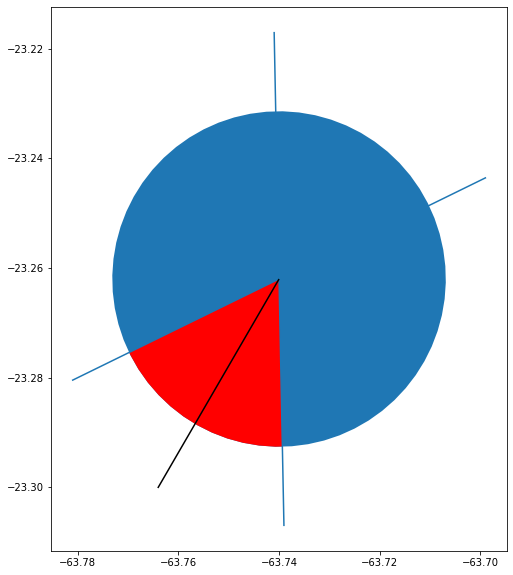

In [296]:
mis_prueba = sectores[sectores['sector']=='ACHAQUN13'].to_crs("EPSG:32614")
mis_prueba.geometry = mis_prueba.geometry.buffer(1000*mis_prueba['radio_de_cobertura'])
mis_prueba = mis_prueba.to_crs(crs='EPSG:4326') 
fi=240.0
the=67.0
angulop=-45+fi-(the/2)
lgdfp=gpd.GeoSeries([LineString([(mis_prueba.geometry.bounds.minx,mis_prueba.geometry.bounds.miny), (mis_prueba.geometry.bounds.maxx,mis_prueba.geometry.bounds.maxy)])
]).rotate(angulop)
lgdfp2=lgdfp.rotate(the)

direp = gpd.GeoSeries(split(lgdfp2.rotate(-the/2).geometry.item(),lgdfp.geometry.item()).geoms[1], crs="EPSG:4326")
resultp = split(mis_prueba.geometry.item(),lgdfp.geometry.item())
if direp.geometry.centroid.intersects(resultp.geoms[0]).iloc[0]:
    resultp = gpd.GeoSeries(resultp.geoms[0], crs="EPSG:4326")
else:
    resultp = gpd.GeoSeries(resultp.geoms[1], crs="EPSG:4326")
resultp = split(resultp.geometry.item(),lgdfp2.geometry.item())
if direp.geometry.centroid.intersects(resultp.geoms[0]).iloc[0]:
    resultp = gpd.GeoSeries(resultp.geoms[0], crs="EPSG:4326")
else:
    resultp = gpd.GeoSeries(resultp.geoms[1], crs="EPSG:4326")
# mis_prueba.geometry=resultp

fig, ax = plt.subplots(figsize=(10, 10))
mis_prueba.geometry.plot(ax=ax)
lgdfp.plot(ax=ax)
lgdfp2.plot(ax=ax)
direp.plot(ax=ax,edgecolor='black')
resultp.plot(ax=ax,facecolor='red')
plt.show()



In [183]:
# se_tocan = direp.geometry.centroid.intersects(resultp.geometry)
# se_tocan
direp.geometry.centroid.intersects(resultp.geoms[0])


C:\Users\jpinelli\AppData\Local\Temp/ipykernel_12796/2640408441.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  direp.geometry.centroid.intersects(resultp.geoms[0])


0    True
dtype: bool

In [374]:
sectores_prueba

,sector,sitio,tecnologia,banda_mhz,latitud,longitud,azimuth,altura,apertura_horizontal,radio_de_cobertura,partido_comuna,localidad,provincia,geometry
0,ACHAQUN11,AN028,4G,700,-23.26200000000000,-63.74000000000000,0.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,"POLYGON ((-63.70811 -23.25375, -63.70739 -23.2..."
1,ACHAQUN12,AN028,4G,700,-23.26200000000000,-63.74000000000000,120.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,"POLYGON ((-63.76846 -23.24638, -63.76713 -23.2..."
2,ACHAQUN13,AN028,4G,700,-23.26200000000000,-63.74000000000000,240.0,36,67.0,4.0,GRL. JOSE DE SAN MARTIN,MISION CHAQUEÃ‘A,SALTA,"POLYGON ((-63.73935 -23.29256, -63.74071 -23.2..."
3,AGPIZAN11,AN034,4G,700,-24.22830000000000,-63.98750000000000,0.0,60,67.0,4.0,ANTA,GENERAL PIZARRO,SALTA,"POLYGON ((-63.95527 -24.21978, -63.95452 -24.2..."
4,AGPIZAN12,AN034,4G,700,-24.22830000000000,-63.98750000000000,120.0,60,67.0,4.0,ANTA,GENERAL PIZARRO,SALTA,"POLYGON ((-64.01619 -24.21242, -64.01512 -24.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71289,ZVTADUN12,SS162,4G,700,-33.77020000000000,-61.98450000000000,150.0,42,67.0,4.0,GENERAL LOPEZ,VENADO TUERTO,SANTA FE,"POLYGON ((-62.02182 -33.76914, -62.02172 -33.7..."
71290,ZVTADUN13,SS162,4G,700,-33.77020000000000,-61.98450000000000,270.0,42,67.0,4.0,GENERAL LOPEZ,VENADO TUERTO,SANTA FE,"POLYGON ((-61.96915 -33.79863, -61.97002 -33.7..."
71291,ZVYPINN11,SN184,4G,700,-30.14590000000000,-60.34350000000000,20.0,33,67.0,4.0,SAN JUSTO,VERA Y PINTADO (ESTACION GUARANIES),SANTA FE,"POLYGON ((-60.31111 -30.13456, -60.30999 -30.1..."
71292,ZVYPINN12,SN184,4G,700,-30.14590000000000,-60.34350000000000,140.0,33,67.0,4.0,SAN JUSTO,VERA Y PINTADO (ESTACION GUARANIES),SANTA FE,"POLYGON ((-60.37766 -30.13957, -60.37682 -30.1..."
